# Dissociation of a water dimer with BigDFT

This notebook is divided in two parts. 

The first one presents how to obtain the last figure presented in the BigDFT tutorial on the dissociation of a water dimer using the fragment approach with a jupyter notebook.

The second part is about comparing the results obtained for a similar system, where a water molecule has been replaced by a OH molecule, and a charge added to the system (this charge may be constrained).

###### First, let the notebook be aware of the BigDFT module
To do that, the simplest way is to source the bigdftvars.sh script as indicated in the [corresponding webpage](http://bigdft.org/Wiki/index.php?title=Prepare_the_environment) of BigDFT website. So if you did not do so, reopen the notebook server in the correct environment.

In [1]:
#write here the position of the BigDFT installation (usually <buildtree>/install/lib/pythonX.X/site-packages)
import os
BIGDFT_PYTHONDIR=os.path.abspath(
    '/Users/maximemoriniere/post-doc/bigdft/bigdft/bigdft/src/python'
    ) #refer to the sources, only for test 
#then update the path
import sys
if BIGDFT_PYTHONDIR not in sys.path: 
    sys.path+=[BIGDFT_PYTHONDIR]

###### Import useful modules

In [2]:
from BigDFT import Logfiles as lf 
from futile import Yaml
import numpy as np
import matplotlib.pyplot as plt
import tarfile
#for interactive plots remove the following line
%matplotlib inline 

###### Definition of functions used to treat the data.

In [3]:
def get_re(archive, re):
    """
    This function retrieves the list of Logfiles instances 
    from the file archived satisfying a regular expression.   
    #function to identify an archive out of its regexp, 
    #solves the bug in re for '*' (solved in Python 2.7.6)
    """
   
    result=[]
    for f in archive.getnames():
        isthere=True
        for pattern in re.split('*'):
            isthere = isthere and (pattern in f)
        if isthere: 
            #print(f)
            filetar = archive.extractfile(f)
            content = filetar.read()
            dictionary = Yaml.yaml.load(stream=content)
            result.append(lf.Logfile(dictionary=dictionary))
    return result


def distance(atoms, positions):
    """
    Calculate the distance between two atoms given the 
    positions (from a logfile) and the id of both atoms,
    that is given by two integers.
    """
    
    if len(atoms) != 2:
        raise ValueError(
            "The length of the list of atoms must equal to 2.")
    #Initialize the list that will contain both atoms positions.
    pos = [] 
    for at in atoms:
        #print("at", at, "positions", positions)
        dico = positions[at]     #atom dico
        element = dico.keys()[0] #atom element
        #print("dico", dico, "element", element)
        pos.append(np.array(dico[element]))
    # Find the difference of positions
    diff = pos[0] - pos[1]
    return np.sqrt(diff.dot(diff))


def shift_energies(energies, shift):
    """
    Function that shifts down all energies by the value of shift
    """
    
    en_len = len(energies)
    return [energies[i]-([shift]*en_len)[i] for i in range(en_len)]


def Ha_to_eV(energies):
    return [ en*27.211396132 for en in energies]

def find_data(regexp, title):
    """
    Given a regexp to find logfiles in a given archive, 
    this function that collects the data needed to plot
    dissociation curves.
    This data is made of the distances between the two water 
    molecules and the total energies of the corresponding dimers.
    A title is also added to the dictionnary, 
    in order to be used as legend for the plots.
    """
    
    data = {'title': title}
    data['logfiles'] = get_re(archive, regexp)
    if len(data['logfiles']) < 1:
        raise ValueError("No logfiles found, try a new regexp.")
    # Find the distance between the two molecules
    data['distances'] = [distance([2, 3], log.astruct['Positions']) 
                         for log in data['logfiles']]
    # Sort the logfiles according to the distances first
    data['logfiles'] = [log for (dist, log) in 
                        sorted(zip(data['distances'], data['logfiles']))]
    # Sort the distances
    data['distances'] = sorted(data['distances'])
    # The energies are listed for increasing distance
    data['energies'] = [log.energy for log in data['logfiles']]
    # Shift the energies and convert them to eV
    ref = data['energies'][-1]
    data['energies'] = Ha_to_eV(shift_energies(data['energies'], ref))
    
    return data

## Dissociation of a water dimer : the BigDFT fragment tutorial

The goal of this exercice is to test the fragment approach of BigDFT and to compare the results against the one obtained using the cubic and the linear versions of BigDFT. This is [*the last exercise of the BigDFT fragment tutorial*](http://bigdft.org/Wiki/index.php?title=Fragment_approach). The studied problem is the dissociation curve of a H2O dimer, the key parameter being the distance between the two water molecules (this distance is defined by the distance between the oxygen atom of one water molecule and the closest hydrogen atom of the other molecule; for all the calculations, the orientations of the water molecules stay the same, so that only a molecule is translated in the different input files).

We have put in the tarfile 'dissociation.tar.gz' the archive of all the logfiles which have been used for the present study.

In [4]:
# Open the tarfile
archive = tarfile.open('dissociation.tar.gz')

Let us now extract the files corresponding to each of the run classes.
We have defined the *find\_data* function so that it returns a python dictionary containg everything we need to plot the data for one class. Each dictionnary has four keys, associated to a value:
* the key 'title' is associated to a string value, that will be used as a legend when plotting.
* the key 'logfiles', associated to a list of logfiles, sorted so that the distance between the two water molecules is increasing.
* the key 'distances', associated to a numpy array of distances,
* the key 'energies', associated to a numpy array of the corresponding energies.

In [5]:
# Open the logfiles according to the regexp and treat the data
cubic    = find_data("*/H2O/cubic/dimer*/log-*yaml", 'Cubic')
lin_1_4  = find_data("*/H2O/linear_1-4/dimer*/log-*yaml", 'Linear 1-4')
frag_1_4 = find_data("*/H2O/fragment_1-4/dimer*/log-*yaml", 'Fragment 1-4')
frag_2_5 = find_data("*/H2O/fragment_2-5/*/log*yaml", 'Fragment 2-5')
frag_5_8 = find_data("*/H2O/fragment_5-8/dimer*/log-*yaml", 'Fragment 5-8')

It is then easy to plot the data, and reproduce the [*plot obtained in the last exercise of the tutorial*](http://bigdft.org/images/b/b1/H2o_binding.png). The explanation is given [*in this article, section II.F*](http://dx.doi.org/10.1063/1.4922378).

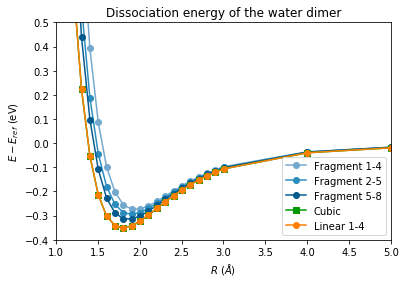

In [6]:
# List of data to be plotted
curves = [frag_1_4, frag_2_5, frag_5_8, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.4, 0.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

## Test of the influence of some input parameters
It is now easy to test the influence of some input parameters on these dissociation curves.

### *nbasis*
A key parameter is the number of support functions per atom type, *nbasis*. Increasing this parameters allows for the inclusion of polarization effects of the charge density due to the presence of a neighboring molecule, therefore reducing the basis set superposition error.

In [7]:
#Change the title for the tutorial calculation frag_1-4
frag_1_4['title'] = 'Fragment 1-4'

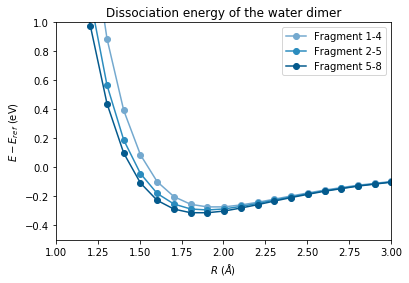

In [8]:
# List of data to be plotted
curves = [frag_1_4, frag_2_5, frag_5_8]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

### *rloc* parameters 
We test here the value of the three rloc parameters. Their signification is introduced in the lin_basis_parameters section [*here*](http://bigdft.org/Wiki/index.php?title=Input_variables).

Increasing them should give more accurate results, but this is not the case here: one could think of reducing this parameter to get a better agreement with cubic and linear calculations. This is only visible because *nbasis* is not large enough.

In [9]:
#Small rlocs (rloc, rloc_foe, rloc_foe_kernel) = (6, 8, 10)
frag_1_4_small_rlocs = find_data("*/H2O/templates_tests/H2O/test7/H2O-dimer/dimer*/log-*yaml",
                                 'Fragment 1-4 small rlocs (6, 8, 10)')

#Large rlocs (rloc, rloc_foe, rloc_foe_kernel) = (11, 14, 16)
frag_1_4_large_rlocs = find_data("*/H2O/templates_tests/H2O/test5/H2O-dimer/dimer*/log-*yaml",
                                 'Fragment 1-4 large rlocs (11, 14, 16)')

In [10]:
#Change the title for the tutorial calculation frag_1-4
frag_1_4['title'] = 'Fragment 1-4 medium rlocs (9, 12, 14) [tuto]'

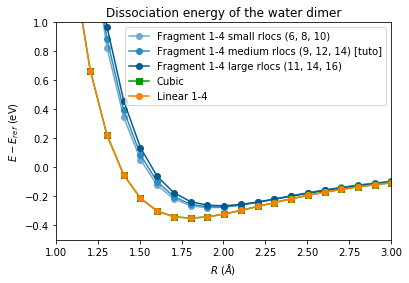

In [11]:
# Chose the dissociation curves to be plotted
curves = [frag_1_4_small_rlocs, frag_1_4, 
          frag_1_4_large_rlocs, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

### *rloc* parameters when increasing *nbasis*
It is shown, with the next plot, that when *nbasis* is large enough, the influence of the *rloc* is not that important anymore. Such a test may help in understanding if *nbasis* is large enough.

In [12]:
#Small rlocs (rloc, rloc_foe, rloc_foe_kernel) = (6, 8, 10)
frag_5_8_small_rloc = find_data("*/H2O/templates_tests/H2O/test9/H2O-dimer/dimer*/log-*yaml",
                                'Fragment 5-8 small rlocs (6, 8, 10)')

#Large rlocs (rloc, rloc_foe, rloc_foe_kernel) = (11, 14, 16)
frag_5_8_large_rloc = find_data("*/H2O/templates_tests/H2O/test8/H2O-dimer/dimer*/log-*yaml",
                               'Fragment 5-8 large rlocs (11, 14, 16)')

In [13]:
#Change the title for the tutorial calculation frag_5_8
frag_5_8['title'] = 'Fragment 5-8 rlocs (9, 12, 14) [tuto]'

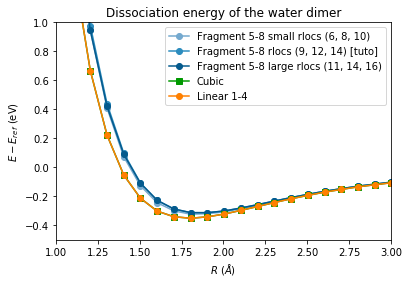

In [14]:
# Chose the dissociation curves to be plotted
curves = [frag_5_8_small_rloc, frag_5_8, 
          frag_5_8_large_rloc, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

### *crmult* and *frmult* parameters
Another key parameters are the grid extensions [*crmult* and *frmult*](http://bigdft.org/Wiki/index.php?title=Basis-set_convergence#crmult.2C_frmult). The values (*crmult*, *frmult*) = (5.0, 7.0) of the tutorial are already OK. A convergence is already reached by increasing them to (7.0, 8.0), but this only slightly modifies the results for small distances.

In [15]:
#Small rlocs (rloc, rloc_foe, rloc_foe_kernel) = (6, 8, 10)
frag_1_4_medium_rm = find_data("*/H2O/templates_tests/H2O/test3/H2O-dimer/dimer*/log-*yaml",
                               'Fragment 1-4 crm 7, frm 8')

#Large rlocs (rloc, rloc_foe, rloc_foe_kernel) = (11, 14, 16)
frag_1_4_large_rm = find_data("*/H2O/templates_tests/H2O/test4/H2O-dimer/dimer*/log-*yaml",
                              'Fragment 1-4 crm 9, frm 8')

In [16]:
#Change the title for the tutorial calculation frag_1-4
frag_1_4['title'] = 'Fragment 1-4 crm 5, frm 7 [tuto]'

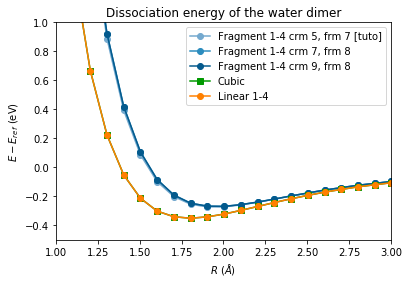

In [17]:
# List of data to be plotted
curves = [frag_1_4, frag_1_4_medium_rm, 
          frag_1_4_large_rm, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

### confinement or not in h2o.yaml and dimer.yaml
This test is about the inclusion or not of two parameters (*ao_confinement* and *confinement*) in the input files. The energies are higer without the confinement for large distances (but close to the results obtaind usingconfinement), while there is a sharp change around 1.75 $\unicode[serif]{xC5}$.

In [18]:
#no confinement
frag_1_4_no_conf = find_data("*/H2O/templates_tests/H2O/test1/H2O-dimer/dimer*/log-*yaml",
                               'Fragment 1-4 without confinement')

In [19]:
#Change the title for the tutorial calculation frag_1-4 and frag_2_5
frag_1_4['title'] = 'Fragment 1-4 with confinement [tuto]'
frag_5_8['title'] = 'Fragment 5-8 with confinement [tuto]'

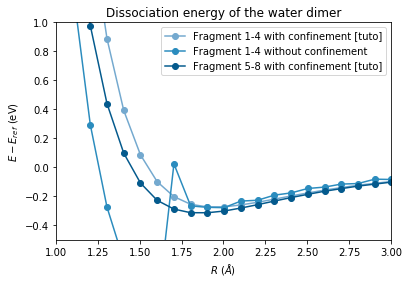

In [20]:
# List of data to be plotted
curves = [frag_1_4, frag_1_4_no_conf, frag_5_8]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

### remove *nit* and *rpnrm_cv* from the dimer.yaml input files
This test is about the importance of "nit: 1" (in lin_basis and lin_kernel) and "rpnrm_cv: 1.0E-010" (in lin_kernel) in the input files. The results are close to the one obtained in the previous test for short distances, except that the sharp change occurs at a distance around 2.0 $\unicode[serif]{xC5}$. Actually, the two "wrong" results are in better agreement at small distance than at high distance. 

In [21]:
#no confinement
frag_1_4_no_nit = find_data("*/H2O/templates_tests/H2O/test2/H2O-dimer/dimer*/log-*yaml",
                               'Fragment 1-4 without nit and rpnrm_cv')

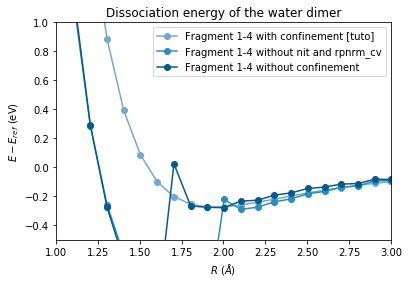

In [22]:
# List of data to be plotted
curves = [frag_1_4, frag_1_4_no_nit, frag_1_4_no_conf]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['title'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

## Dissociation of a H$_2$O - HO$^-$ dimer

In this part of the notebook, the system under study has the same number of electrons as before, but is lacking a hydrogen atom. Cubic simulations have been done (no full linear simulations yet) as well as fragment approach simulations.

The goal of this part of the notebook is to illustrate how to use constrained DFT in the fragment approach with BigDFT. Two initial setups were used: one using OH as a template, the other using OH$^-$ as the template. Constrained DFT can be applied on top of that, in order to force the added electron to remain in the OH fragment.

In [23]:
# Open the logfiles according to the regexp and treat the data
cubic_OHm = find_data("*/OH-/cubic/r-*/log-*yaml", 'Cubic OH$^-$')
OHm       = find_data("*/OH-/oh-/r-*/log-*yaml", 'OH$^-$')
OHm_CDFT  = find_data("*/OH-/oh-_CDFT/r-*/log-*yaml", 'OH$^-$ (CDFT)')
OH_m      = find_data("*/OH-/oh_-1/r-*/log-*yaml", 'OH + $e^-$')
OH_m_CDFT = find_data("*/OH-/oh_-1_CDFT/r-*/log-*yaml", 'OH + $e^-$ (CDFT)')

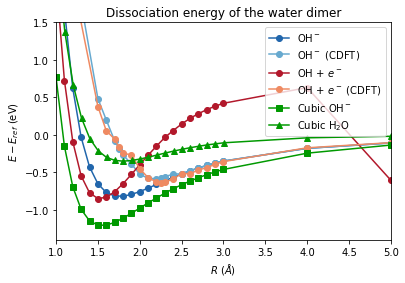

In [24]:
# List of data to be plotted
curves = [OHm, OHm_CDFT, OH_m, OH_m_CDFT, 
          cubic_OHm, cubic]
#Change the title of the cubic plot
cubic['title'] = 'Cubic H$_2$O'
# Lists of markers and colors (for matplotlib)
colors = ['#2166ac', '#67a9cf', '#b2182b', '#ef8a62', '#009900', '#009900']
markers = ['o']*4+['s']+['^']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['title'], color=colors[i])
plt.ylim([-1.4, 1.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

## Some functions that might become useful someday

In [25]:
def shift_positions(astruct):
    """
    Function that returns a structure with the positions 
    shifted back to the initial posinp. 
    Works only when units are in angstroem.
    """
    if astruct['Units'] != 'angstroem':
        raise ValueError('Units must ne in angstroem')
    au_to_angs = 0.529177249
    new_struct = {}
    #Find the shift, and convert it to angstroem
    shift = [shift*au_to_angs 
             for shift in struct['Rigid Shift Applied (AU)']]
    #Loop over each atom in the structure
    new_pos = []
    for elem in astruct['Positions']:
        for at, pos in elem.items():
            pos = [pos[i]-shift[i] for i in range(3)]
            new_pos.append({at: pos})
    new_struct['Positions'] = new_pos
    new_struct['Units'] = 'angstroem'
    new_struct['Rigid Shift Applied (AU)'] = [0.0, 0.0, 0.0]
    return new_struct

In [26]:
# Test of the newly defined function
struct = cubic['logfiles'][0].astruct
print(struct)
#print(struct['Positions'])
new_struct = shift_positions(struct)
print(new_struct)

{'Units': 'angstroem', 'Positions': [{'O': [4.283920014, 4.535053583, 4.072136104]}, {'H': [3.85964432, 4.49839703, 4.914649016]}, {'H': [5.212319619, 4.541508696, 4.243170943]}, {'O': [6.215398014, 4.526799584, 4.302962104]}, {'H': [6.512229014, 5.292627584, 3.837580104]}, {'H': [6.488934014, 3.782761584, 3.790316104]}], 'Rigid Shift Applied (AU)': [9.8557, 8.5614, 7.9169]}
{'Units': 'angstroem', 'Positions': [{'O': [-0.9314921989692992, 0.004555483411399663, -0.11730725860809965]}, {'H': [-1.3557678929692996, -0.032101069588600595, 0.7252056533919005]}, {'H': [-0.0030925939693000615, 0.011010596411400009, 0.053727580391900176]}, {'O': [0.9999858010307001, -0.0036985155886002374, 0.11351874139189988]}, {'H': [1.2968168010307002, 0.7621294844113997, -0.35186325860809964]}, {'H': [1.2735218010307001, -0.7477365155886, -0.39912725860809983]}], 'Rigid Shift Applied (AU)': [0.0, 0.0, 0.0]}


In [27]:
def water_distance_from_paths(paths):
    """
    Function that returns the distance between
    the two water molecules from the paths.
    """
    ##for path in paths:
    ##    print(path, path.split('_'))
    ##    print(path, path.split('_')[-1])
    ##    print(path, float(path.split('_')[-1][:-len('/log-dimer.yaml')]))
    return [float(path.split('_')[-1][:-len('/log-dimer.yaml')]) \
            for path in paths]